# 3 - Level Flying Cap Converter

<a href="https://colab.research.google.com/github/idea-fasoc/OpenFASOC/blob/main/docs/source/notebooks/temp_sense_genCollab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
AC3E Microelectronics Team, November 2022
SPDX-License-Identifier: Apache-2.0
```


|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
| Jorge Marín <br /> Email ID: jorge.marinn@usm.cl|AC3E (Chile)| No |No|
| Christian Rojas <br /> Email ID: c.a.rojas@ieee.org|AC3E, Universidad Técnica Federico Santa María (Chile)| Yes |No|
| Joel Gak |Universidad Católica de Uruguay (Uruguay)| No |No|
| Nicolás |Universidad Católica de Uruguay (Uruguay)| No |No|
| Alfonso Cortés |AC3E, Universidad Técnica Federico Santa María (Chile)| Yes |No|
| Aquiles Viza |AC3E, Universidad Técnica Federico Santa María (Chile)| No |No|
| Kevin Pizarro |Universidad Técnica Federico Santa María (Chile)| No |No|
| Sebastián Neira |AC3E, Universidad Técnica Federico Santa María (Chile)| No |No|
| Vicente Osorio |Universidad Técnica Federico Santa María (Chile)| No |No|
| Tomás Velásquez|Universidad Técnica Federico Santa María (Chile)| No |No|
| Max Vega |Universidad Técnica Federico Santa María (Chile)| No |No|
| Julio Contreras |Universidad Técnica Federico Santa María (Chile)| No |No|
| Diego Almonacid |Universidad Técnica Federico Santa María (Chile)| No |No|
| Carolina Beckmann |Universidad Técnica Federico Santa María (Chile)| Yes |No|
| Pablo Vera |Universidad Técnica Federico Santa María (Chile)| No |No|


## Introduction

Our project focuses on designing and implementing a DC-DC buck converter demonstrator based on the three-level flying capacitor converter (3L-FCC) architecture, a simple but versatile type of FCML converter, using the Skywater 130nm CMOS technology (SKY130). Since power conversion at low voltage levels has already been demonstrated in the SKY130 technology in previous work [7], we set our focus on the buck conversion block between the high voltages in solar panels (20V) and the intermediate unregulated voltages in the DC bus (12V) for photo-voltaic input channel in CubeSat applications. In our proposed architecture and topologies, depicted in Fig. 2, the power circuits are fully integrated on-chip, including the power MOSFETs (PM), the flying capacitor (FC) and the gate drivers (GD). The switching control will be delivered externally or using the integrated RISC-V module, to allow for experiments with different modulation and control schemes. 

**Aún por cambiar**>>

**_Index Terms:_** Circuit generator, leakage-based temperature dependency, open source, synthesizable design, temperature sensor.

Citation: Q. Zhang et al., "An Open-Source and Autonomous Temperature Sensor Generator Verified With 64 Instances in SkyWater 130 nm for Comprehensive Design Space Exploration," in IEEE Solid-State Circuits Letters, vol. 5, pp. 174-177, 2022, doi: 10.1109/LSSC.2022.3188925.


[^1]: This notebook is targeted at users of all professional backgrounds aiming to learn how to *code* their chips. The goal is to go through all the steps of generating the temperature sensor and an overview of the simulation results. 

## About the converter and level shifters

In general, this converter allows flexibility for control and gives the possibility of achieving better signal quality, but also the option of using it as a buck or boost converter. In this case, it is being used as a buck converter.
This converter works on 4 states, described in figure 1, as seen below. 

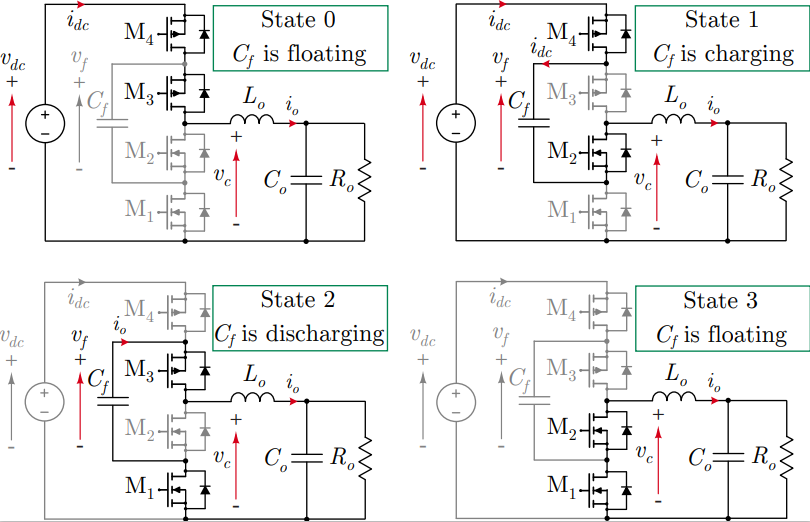

Yet for achieving the logic levels necessary for other applications that are normally higher than the ones at the chip, so it is necessary to use level shifters. The level shifters used in this project are the ones depicted in figure 2.

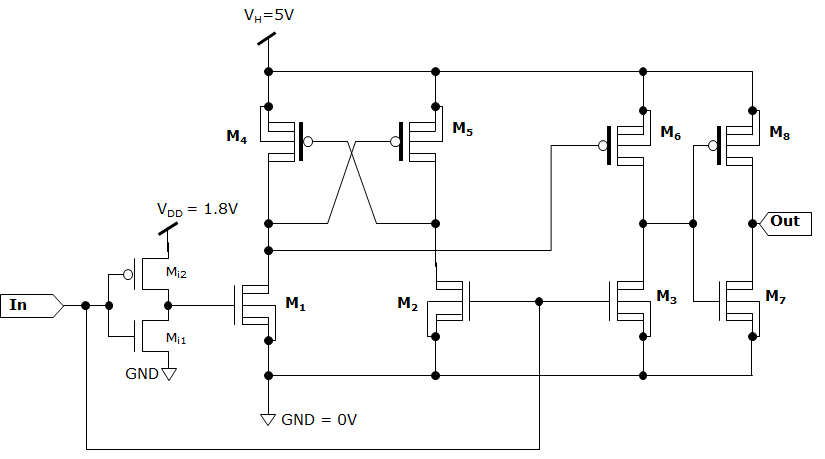

## Install tools and dependencies

In [ ]:
# install all tools and dependencies
import os
import pathlib
import sys

!pip install matplotlib pandas pyinstaller
!apt-get install -y ruby-full time build-essential
!apt install -f libqt4-designer libqt4-xml libqt4-sql libqt4-network libqtcore4 libqtgui4
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a \
                        magic \
                        netgen \
                        openroad \
                        yosys
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        tcllib gdstk pyyaml click svgutils ngspice
#!bin/micromamba install --yes --prefix $CONDA_PREFIX \
#                        --channel conda-forge \
#                        klayout

!wget https://www.klayout.org/downloads/Ubuntu-18/klayout_0.27.11-1_amd64.deb
!dpkg -i klayout_0.27.11-1_amd64.deb

# clone OpenFASOC repo
!git clone https://github.com/idea-fasoc/OpenFASOC
# setup env
OPENFASOC_ROOT=str(pathlib.Path('OpenFASOC').resolve())
TEMP_SENSE_ROOT=OPENFASOC_ROOT+"/openfasoc/generators/temp-sense-gen/"
PATH=os.environ['PATH']
%env PDK_ROOT={CONDA_PREFIX}/share/pdk
%env OPENFASOC_ROOT={OPENFASOC_ROOT}
%env PATH={PATH}:{OPENFASOC_ROOT}:{OPENFASOC_ROOT}/openfasoc/generators/temp-sense-gen/tools
# pip3 packages
!apt install python3-pip
!pip3 install matplotlib pandas pyinstaller ipykernel

## Simulation

The switch design is initially based on the 10V thick oxide NMOS and PMOS power devices implemented in the Open PMIC project. The device sizes are shown below.

**ver si esto va**


### PMOS characterization

Below, there will be two sections that have parameters that can be tweaked for the case to be analyzed by the user, both being the schematic and the python file used to manipulate the data.

#### Generating the data
This cell allows to run the .sch file for calculating the PMOS Ron characteristic through a SPICE simulation

In [ ]:
!xschem PMOS_allfingers_RONcalc_v2p2_20220626.sch -n -S

#### Running the plot 

This cell allows to run a .py file to plot the R_ON characteristic for a PMOS for different VGS values by using the data generated by the .sch file.

The R_ON value for the typical PMOS switch device at 70°C , without parasitics, for IDS = 300mA, **is roughly 0.28Ohm** (see plot below).

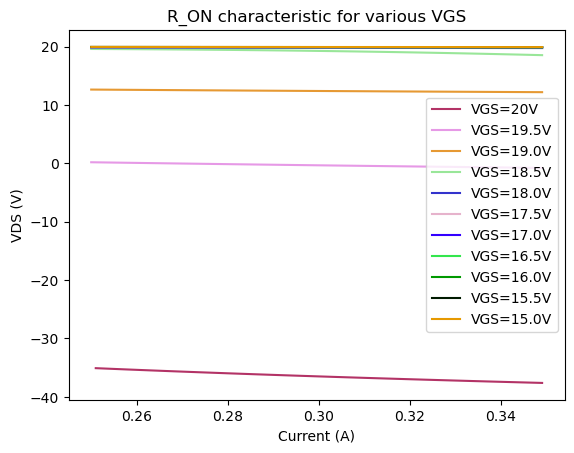

In [7]:
import pandas as pd
import numpy as np
import random as rand
from matplotlib import pyplot as plt

colors=(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1)
df=pd.read_fwf('PMOS_R_on_calc.txt')
df.to_csv('PMOS_R_on_calc.csv', index=False)
data = pd.read_csv('PMOS_R_on_calc.csv').values

## If you want to change the start, stop and step in the .sch file, you may change this parameters
## here, named start, stop and step.
start=20
stop=15
step=0.5
VGS=[]
while start>=stop:
    VGS.append('VGS='+str(start)+'V')
    start-=step

## If you want to change the current sweep step  in the for more data, you may change this parameter
## here, named current_sweep_step.
current_sweep_step=100
under=0
top=current_sweep_step-1   

row1=0
row2=0
i=0

flag=True
for volt in VGS:
    
    row1=under
    row2=top
    if flag:
        under+=current_sweep_step
        flag=False
    else:
        under+=current_sweep_step+1
    top+=current_sweep_step+1
    if volt==VGS[0]:
        current = data[0:row2,0]
        voltage = data[0:row2,1]
    else:
        current = data[row1:row2,0]
        voltage = data[row1:row2,1]
    plt.plot(current,voltage, color=(rand.choice(colors),rand.choice(colors),rand.choice(colors)),label=volt)
    
plt.xlabel('Current (A)')
plt.ylabel('VDS (V)')
plt.title('R_ON characteristic for various VGS')
plt.legend()
plt.show()  

### NMOS charactherization

Below, there will be two sections that have parameters that can be tweaked for the case to be analyzed by the user, both being the schematic and the python file used to manipulate the data.

#### Opening and simulating the schematic
This cell below allows to run the .sch file for calculating the NMOS R_ON characteristic through a SPICE simulation

In [ ]:
!xschem NMOS_allfingers_RONcalc_v2p2_20220626.sch -n -S

#### Running the plot

This cell allows to run a .py file to plot the R_ON characteristic for a NMOS for different VGS values by using the data generated by the .sch file

The R_ON value for the typical NMOS switch device at 70°C , without parasitics, for IDS = 300mA, **is roughly 0.17Ohm** (see plot below).

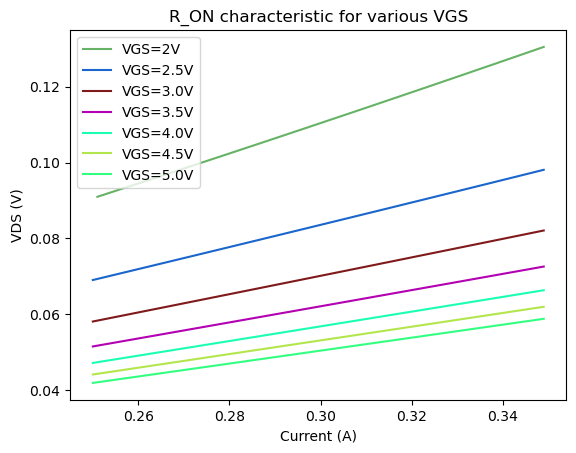

In [8]:
import pandas as pd
import numpy as np
import random as rand
from matplotlib import pyplot as plt

colors=(0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1)
df=pd.read_fwf('NMOS_R_on_calc.txt')
df.to_csv('NMOS_R_on_calc.csv', index=False)
data = pd.read_csv('NMOS_R_on_calc.csv').values

## If you want to change the start, stop and step in the .sch file, you may change this parameters
## here, named start, stop and step.
start=2
stop=5
step=0.5
VGS=[]
while start<=stop:
    VGS.append('VGS='+str(start)+'V')
    start+=step

## If you want to change the current sweep step  in the for more data, you may change this parameter
## here, named current_sweep_step.
current_sweep_step=100
under=0
top=current_sweep_step-1   

row1=0
row2=0
i=0

flag=True
for volt in VGS:
    
    row1=under
    row2=top
    if flag:
        under+=current_sweep_step
        flag=False
    else:
        under+=current_sweep_step+1
    top+=current_sweep_step+1
    if volt==VGS[0]:
        current = data[0:row2,0]
        voltage = data[0:row2,1]
    else:
        current = data[row1:row2,0]
        voltage = data[row1:row2,1]
    plt.plot(current,voltage, color=(rand.choice(colors),rand.choice(colors),rand.choice(colors)),label=volt)
    
plt.xlabel('Current (A)')
plt.ylabel('VDS (V)')
plt.title('R_ON characteristic for various VGS')
plt.legend()
plt.show()  

### Efficiency

Below, there will be two sections that have parameters that can be tweaked for the case to be analyzed by the user, both being the schematic and the python file used to manipulate the data.


#### Opening and simulating the schematic

This cell allows to run the .sch file for calculating the efficiency of a core from the converter through a SPICE simulation.

In [ ]:
!xschem core_testbench_wfilter.sch -n -S

#### Running the plot

This cell allows to run a .py file to plot the converter efficiency, with and without level shifters involved, for different load values by using the data generated by the .sch file

The R_ON value for the typical NMOS switch device at 70°C , without parasitics, for IDS = 300mA, **is roughly 0.17Ohm** (see plot below).

Load: 50 ohms
Peak length: 23
Efficiency: 86.97203714402934 %
Efficiency (considering level shifter): 82.2455254221848 %
Load: 45 ohms
Peak length: 21
Efficiency: 87.59617740255412 %
Efficiency (considering level shifter): 83.1486848316201 %
Load: 40 ohms
Peak length: 21
Efficiency: 87.91237613782668 %
Efficiency (considering level shifter): 83.8956320262659 %
Load: 35 ohms
Peak length: 22
Efficiency: 88.75036300102734 %
Efficiency (considering level shifter): 83.44140797547146 %
Load: 30 ohms
Peak length: 22
Efficiency: 89.52566569897684 %
Efficiency (considering level shifter): 84.44967251634998 %
Load: 25 ohms
Peak length: 23
Efficiency: 89.82483646550783 %
Efficiency (considering level shifter): 86.61060670142469 %
Load: 20 ohms
Peak length: 23
Efficiency: 90.61621334976422 %
Efficiency (considering level shifter): 87.87913625258177 %
Load: 15 ohms
Peak length: 22
Efficiency: 91.31973346773229 %
Efficiency (considering level shifter): 88.99721335510432 %
Load: 10 ohms
Peak length: 

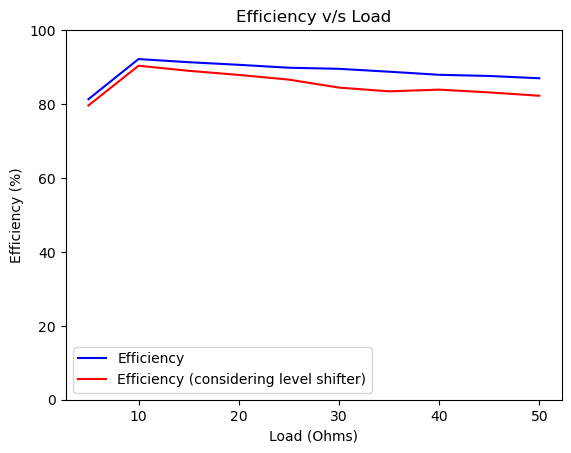

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks

df=pd.read_fwf('3LFCC_core_wfilter_vicente.txt')
df.to_csv('3LFCC_core_wfilter_vicente.csv', index=False)
data = pd.read_csv('3LFCC_core_wfilter_vicente.csv').values



start=50
stop=5
step=5
r=[]
while start>=stop:
    r.append(start)
    start-=step
i_cut = 2000
i=0
pk_init = 10
eff_arr=[]
eff_ls_arr=[]


for res in r:
    flag=True
    for number in data:
        if flag:
            row1=i+i_cut
            flag=False
        if round(number[0],5)==0.00003:
            row2=i
            i+=1
            break
        i+=1
    print('Load:',res,'ohms')
    y_out = data[row1:row2,1]
    data_iout = data[row1:row2,7]
    y_in = (-1)*data[row1:row2,3]
    y_in_LS = (-1)*data[row1:row2,5]
    peaks , _ = find_peaks(y_in, height=0.7)
    pk_len = len(peaks)
    print('Peak length:',pk_len)
    vout = np.mean(y_out[peaks[pk_init]:peaks[pk_len-1]])
    iin = np.mean(y_in[peaks[pk_init]:peaks[pk_len-1]])
    ils = np.mean(y_in_LS[peaks[pk_init]:peaks[pk_len-1]])
    iout = np.mean(data_iout[peaks[pk_init]:peaks[pk_len-1]])
    pout = vout*iout
    pin = 5*iin
    eff_ls = (pout/(5*(iin+ils)))*(100)
    eff = (pout/pin )*(100)
    eff_arr.append(eff)
    eff_ls_arr.append(eff_ls)
    print('Efficiency:',eff,'%')
    print('Efficiency (considering level shifter):',eff_ls,'%')



plt.plot(r,eff_arr,color='b',label='Efficiency')
plt.plot(r,eff_ls_arr,color='r',label='Efficiency (considering level shifter)')
plt.xlabel('Load (Ohms)')
plt.ylabel('Efficiency (%)')
plt.title('Efficiency v/s Load')
plt.legend()
plt.ylim([0,100])
plt.show()

## Analog Layout Generation

...

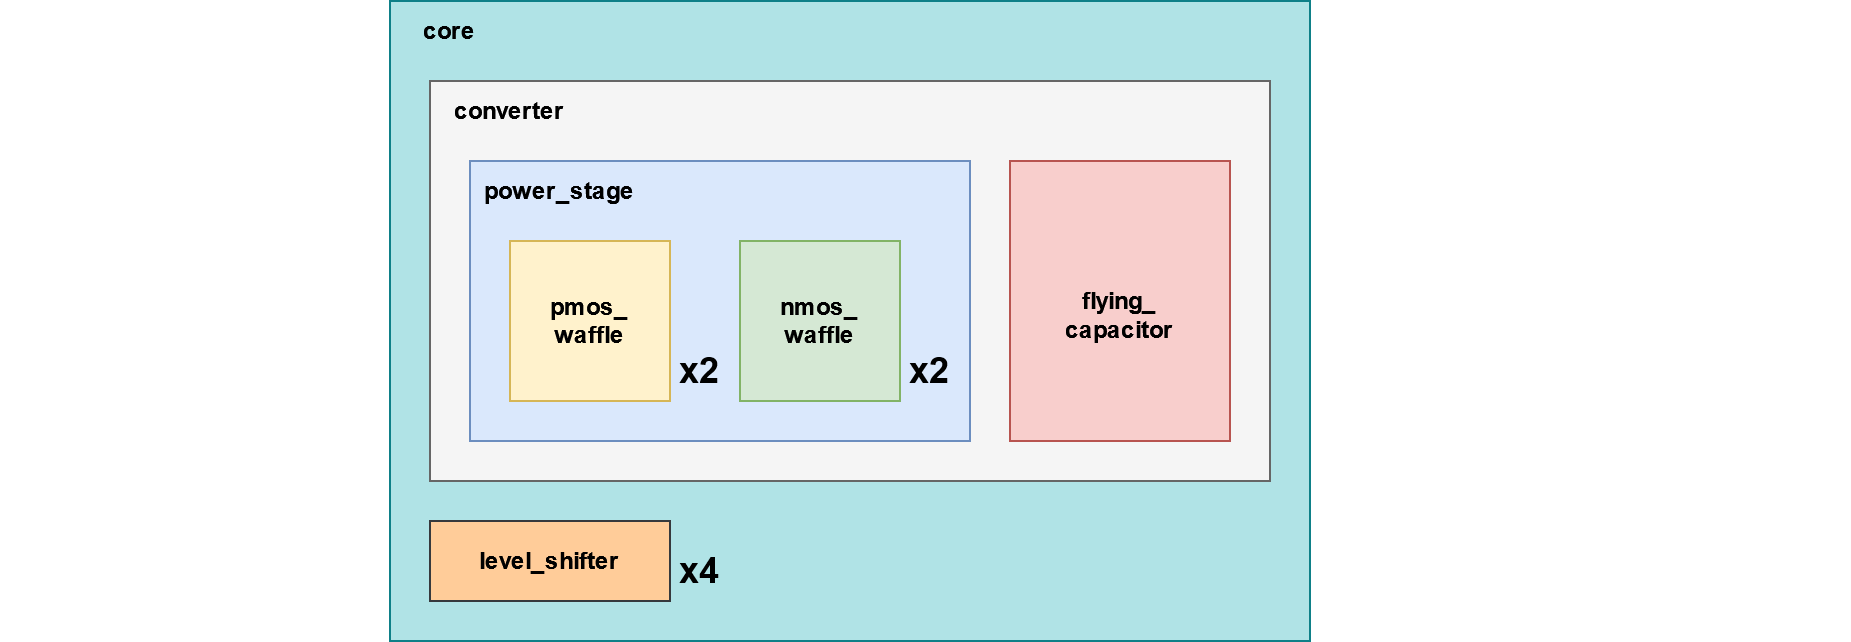

### Custom size Flying Capacitor

It is not recommended to make capacitors bigger than 30um because the size of the metal grains is around 30um, and metals wider than that have lower conductivity. Then, a 30um 'unitary' capacitor is the building block for the flying_cap. The size of the matrix of capacitors depends on the required capacitance. Both MIM capacitor layers available in the sky130 process are used.
The following python code writtes a tcl script that will make a matrix of unitary capacitors, with a certain number of rows (columns number is fixed to better fit the interface of the power_stage).

In [ ]:
# Configurable Parameter
rows = 53 #Number of rows
#Estimated capacitance is:

In [ ]:
# Making of the tcl file
fileName = input(".mag file name: ")
f = open("cap_matrix.tcl","w")
f.write("# #####################\t#\n#\tAC3E - UTFSM\t\t#\n#\tProject: 3LFCC\t\t#\n#\tCap matrix layout\t#\n# #####################\t#\n\n")
f.write("getcell unit_cap.mag\n")
f.write("set boxS [box size]\nset boxV [box values]\n")
f.write("undo\n")
for column in range(0,43):
    for cap in range(0,rows):
        f.write("select clear\n")
        f.write("move to [expr {[lindex $boxV 0]+[lindex $boxS 0]*"+str(column)+"}]i [expr {[lindex $boxV 1]+[lindex $boxS 1]*"+str(cap)+"}]i\n")
        f.write("getcell unit_cap.mag\n")
            
f.write("save\n")
f.close()

Then run the generated tcl in magic

In [ ]:
!VAR=rows magic -dnull -noconsole
!source cap_matrix.tcl
!exit

Finally, metal terminals are added and the flying_capacitor is finished.

In [ ]:
!magic -dnull -noconsole flying_cap.tcl
!exit

### Convert Core
...

In [ ]:
!magic -dnull -noconsole core.tcl
!exit

A .gds file has been generated for the topmodule, along with a netlist (.spice) extracted from the layout.

## Layout v/s Schematic